<h1>Import frameworks</h1>

In [46]:
import numpy as np
import pandas as pd
import glob
import errno
import re
import locale
import datetime
import matplotlib as mpl
from matplotlib import pyplot
from bs4 import BeautifulSoup
locale.setlocale(locale.LC_TIME, "sv_SE") # For Swedish dates

'sv_SE'

<h1>Cleaning methods</h1>

In [191]:
date_obj = lambda dateText: datetime.datetime.strptime(dateText.replace('Såld ','').strip(), '%d %B %Y')

def cleanLocation(locationText):
    locationText.span.decompose()        
    stripped = locationText.text.strip().replace("\n", "")
    splitted = stripped.split(',')
    locationList = list(map(lambda x: x.strip(), splitted))
    return ", ".join(locationList)

def areaAndRoom(areaText):
    areaText.span.decompose() if areaText.span else areaText
    areaAndRoom = re.findall(r'\d+', areaText.text.strip())   
    areaAndRoomList = list(map(lambda x: x.strip(), areaAndRoom))
    intList = [eval(i) for i in areaAndRoomList]
    area = 0
    room = 0
    errors = 0
    try:
        area = intList[0]
        room = intList[1]
    except IndexError:
        errors += 1
    #print('Errors ' + errors.__str__())
    return area, room

def cleanLandArea(landAreaText):
    landAreaText = landAreaText.replace('\u00a0','')
    return zeroIfNoNumber(landAreaText)

def cleanPrice(priceText):
    priceText = priceText.replace('Slutpris','')
    priceText = priceText.replace('kr','')
    priceText = priceText.replace('\u00a0','')
    return zeroIfNoNumber(priceText)

def zeroIfNoNumber(valueText):
    value = re.findall(r'\d+', valueText)
    if value.__len__() > 0:
        value = int(value[0])
    else:
        value = 0
    return value

<h1>Parse Entity</h1>

In [192]:
def parseObject(obj):
        dateText = obj.find('span',attrs={'class':'hcl-label hcl-label--state hcl-label--sold-at'}).text
        addressText = obj.find('h2',attrs={'class':'sold-property-listing__heading qa-selling-price-title hcl-card__title'}).text
        locationText = obj.find('span',attrs={'class':'property-icon property-icon--result'}).parent
        areaText = obj.find('div',attrs={'class':'sold-property-listing__subheading sold-property-listing__area'})
        extraAreaText = obj.find('span',attrs={'class':'listing-card__attribute--normal-weight'}).text if obj.find('span',attrs={'class':'listing-card__attribute--normal-weight'}) else ''
        landAreaText = obj.find('div',attrs={'class':'sold-property-listing__land-area'}).text if obj.find('div',attrs={'class':'sold-property-listing__land-area'}) else ''
        priceText = obj.find('span',attrs={'class':'hcl-text hcl-text--medium'}).text
        area, room = areaAndRoom(areaText)
        return [date_obj(dateText), addressText.strip(), cleanLocation(locationText), area, zeroIfNoNumber(extraAreaText), room, cleanLandArea(landAreaText), cleanPrice(priceText)]


<h1> Parse files</h1>

In [193]:
dir_path = '../kungalv_slutpriser/*.html' 
files = glob.glob(dir_path)
entities = pd.DataFrame(columns=['Date','Address','Location','Area','ExtraArea','Room', 'LandArea','Price'])
for name in files:
    try:
        with open(name) as f:
            soup = BeautifulSoup(f, "html.parser")
            objects = soup.findAll('li',attrs={'class':'sold-results__normal-hit'})
            for obj in objects:
                entity = parseObject(obj)
                entities.loc[len(entities.index)] = entity 
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

print(entities.head())

        Date              Address                        Location  Area  \
0 2017-11-23          Sjöhåla 580     Kovikshamn, Kungälvs kommun    94   
1 2017-11-18       Galeasgatan 15        Kungälv, Kungälvs kommun   103   
2 2017-11-17  Västerhöjdsvägen 36          Kärna, Kungälvs kommun   107   
3 2017-11-16     Gråstensvägen 19  Kode Halltorp, Kungälvs kommun    94   
4 2017-11-16           Hägnan 135         KAREBY, Kungälvs kommun   235   

   ExtraArea  Room  LandArea    Price  
0         87     5      1068  3100000  
1         64     5       610  3850000  
2          0     5       258  4000000  
3          0     5      1197  3200000  
4          0     6    104335  8800000  


In [196]:
entities.to_csv('entities.csv', index=False, encoding='utf-8')

<h1>Plots</h1>

count    1.973000e+03
mean     4.233211e+06
std      1.657449e+06
min      2.500000e+05
25%      3.200000e+06
50%      4.100000e+06
75%      5.035000e+06
max      2.100000e+07
Name: Price, dtype: float64


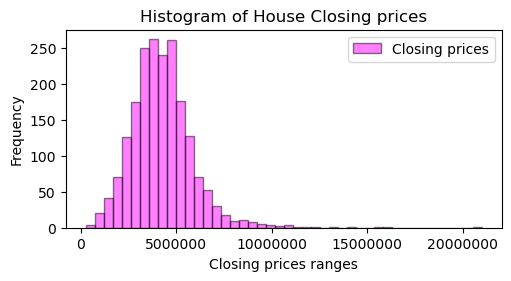

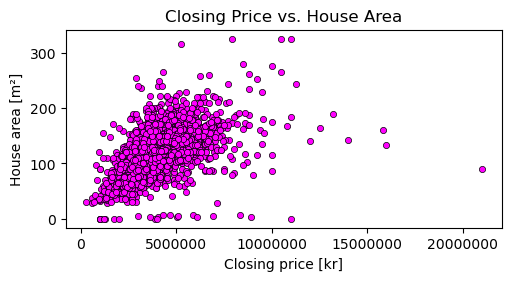

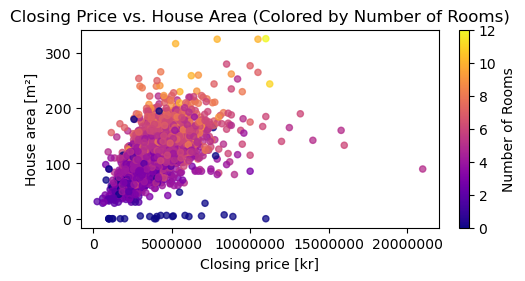

In [99]:
entities = pd.read_csv('entities.csv')
#print(entities.head())
print(entities['Price'].describe())

# Plot hisogram of closing prices
num_bins = int(len(entities['Price']) ** 0.5)
fig1, ax1 = pyplot.subplots(figsize=(5, 2.7), layout='constrained')
ax1.hist(entities['Price'], bins=num_bins, color='magenta', edgecolor='black', linewidth=1, alpha=0.5, label='Closing prices')
ax1.set_xlabel('Closing prices ranges')  # Add an x-label to the axes.
ax1.set_ylabel('Frequency')  # Add a y-label to the axes.
ax1.set_title("Histogram of House Closing prices")  # Add a title to the axes.
ax1.legend(loc='upper right')
ax1.ticklabel_format(useOffset=1, style='plain', axis='x')


# Plot Closing Price vs. House Area
fig2, ax2 = pyplot.subplots(figsize=(5, 2.7), layout='constrained')
ax2.scatter(entities['Price'], entities['Area'], s=20, color='magenta', edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Closing price [kr]')  # Add an x-label to the axes.
ax2.set_ylabel('House area [m²]')  # Add a y-label to the axes.
ax2.set_title("Closing Price vs. House Area")  # Add a title to the axes.
ax2.ticklabel_format(useOffset=1, style='plain', axis='x')


# Plot Closing Price vs. House Area (Colored by Number of Rooms)
fig3, ax3 = pyplot.subplots(figsize=(5, 2.7), layout='constrained')
ax3.scatter(entities['Price'], entities['Area'],  c=entities['Room'], cmap='plasma', s=20, alpha=0.75)
ax3.set_xlabel('Closing price [kr]')  # Add an x-label to the axes.
ax3.set_ylabel('House area [m²]')  # Add a y-label to the axes.
ax3.set_title("Closing Price vs. House Area (Colored by Number of Rooms)")  # Add a title to the axes.
sm = pyplot.cm.ScalarMappable(cmap='plasma') 
sm.set_array(entities['Room']) 
fig3.colorbar(sm,  label='Number of Rooms', ax=pyplot.gca()) 
ax3.ticklabel_format(useOffset=1, style='plain', axis='x')


